# Compare GCHP versus GCHP

## Overview of this Notebook

* Import dependencies
* Define general utility functions
* Define functions for regridding
* Define functions for plotting
* Define data directories
* Make regridding weights
* Store areas for normalization
* Compare restart files
* Compare diagnostic collections

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('/n/home08/elundgren/GC/python/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Define general utility functions

In [2]:
def get_gchp_filepath(outputdir, collection, day, time):
    filepath = os.path.join(outputdir, 'GCHP.{}.{}_{}z.nc4'.format(collection,day,time))
    return filepath

In [3]:
def check_paths( gchp_path1, gchp_path2):
    if not os.path.exists(gchp_path1):
        print('ERROR! First GCHP path does not exist: {}'.format(gchp_path1))
    else:
        print('First GCHP path exists: {}'.format(gchp_path2))
    if not os.path.exists(gchp_path2):
        print('ERROR! Second GCHP path does not exist: {}'.format(gchp_path2))
    else:
        print('Second GCHP path exists: {}'.format(gchp_path2))

In [4]:
def compare_varnames(dgchp1, dgchp2):
    
    # Find common variables in collection by generating lists and list overlap
    gchp1vars = [k for k in dgchp1.data_vars.keys()]
    gchp2vars= [k for k in dgchp2.data_vars.keys()]
    commonvars = sorted(list(set(gchp1vars).intersection(set(gchp2vars))))
    gchp1only = [v for v in gchp1vars if v not in gchp2vars]
    gchp2only = [v for v in gchp2vars if v not in gchp2vars]
    dimmismatch = [v for v in commonvars if dgchp1[v].ndim != dgchp2[v].ndim]
    commonvars2D = [v for v in commonvars if dgchp1[v].ndim == 3]
    commonvars3D = [v for v in commonvars if dgchp2[v].ndim == 4]
    
    # Print information on common and mismatching variables, as well as dimensions
    print('{} common variables ({} are 2-dim and {} are 3-dim)'.format(len(commonvars), len(commonvars2D), len(commonvars3D)))
    if len(gchp1only) > 0:
        print('{} variables in first gchp file only (skip)'.format(len(gchp1only)))
        print('   Variable names: {}'.format(gchp1only))
    if len(gchp2only) > 0:
        print('{} variables in second gchp file only (skip)'.format(len(gchp2only)))
        print('   Variable names: {}'.format(gchp2only))
    if len(dimmismatch) > 0:
        print('{} common variables have different dimensions'.format(len(dimmismatch)))
        print('   Variable names: {}'.format(dimmismatch))
        
    return [commonvars, commonvars2D, commonvars3D]

In [5]:
def get_stats(dgchp1, dgchp2, varname):
    ds_gchp1_var = dgchp1[varname]
    ds_gchp2_var = dgchp2[varname]
    print('Variable array type: {}'.format(type(ds_gchp1_var)))
    print('Variable values array type: {}'.format(type(ds_gchp1_var.values)))
    print('Array shapes:')
    print('    GCHP 1:  {}'.format(ds_gchp1_var.shape))
    print('    GCHP 2: {}'.format(ds_gchp2_var.shape))
    print('Global Mean:')
    print('    GCHP 1:  {}'.format(np.round(ds_gchp1_var.values.mean(),20)))
    print('    GCHP 2: {}'.format(np.round(ds_gchp2_var.values.mean(),20)))
    print('Global Min:')
    print('    GCHP 1:  {}'.format(np.round(ds_gchp1_var.values.min(),20)))
    print('    GCHP 2: {}'.format(np.round(ds_gchp2_var.values.min(),20)))
    print('Global Max:')
    print('    GCHP 1:  {}'.format(np.round(ds_gchp1_var.values.max(),20)))
    print('    GCHP 2: {}'.format(np.round(ds_gchp2_var.values.max(),20)))

## Define functions for regridding

These functions utilize the xESMF package and the cubedsphere package developed by Jaiwei Zhuang, a graduate student at Harvard University. More specifically I use the cubedsphere package CSGrid class and the xESMF package Regridder class. The latter serves as a wrapper for the ESMF/ESMPy packages. These tools enable simple conservative regridding between lat/lon and cubed sphere horizontal grids as specifically defined by the NASA Global Modeling and Assimilation Office (GMAO). See http://xesmf.readthedocs.io/en/latest/ and https://github.com/JiaweiZhuang/cubedsphere for more information. 

In [6]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

In [7]:
def make_grid_CS(csres):
    csgrid = cs.csgrid_GMAO(csres)
    csgrid_list = [None]*6
    for i in range(6):
        csgrid_list[i] = {'lat': csgrid['lat'][i], 
                          'lon': csgrid['lon'][i],
                          'lat_b': csgrid['lat_b'][i], 
                          'lon_b': csgrid['lon_b'][i]}
    return [csgrid, csgrid_list]

In [8]:
def make_regridder_C2L( csres_in, llres_out, weightsdir='.', reuse_weights=False,  ):
    csgrid, csgrid_list = make_grid_CS(csres_in)
    llgrid = make_grid_LL(llres_out)
    regridder_list = []
    for i in range(6):
        weightsfile = os.path.join(weightsdir, 'conservative_c{}_{}_{}.nc'.format(str(csres_in), llres_out, str(i)))
        regridder = xe.Regridder(csgrid_list[i], llgrid, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
        regridder_list.append(regridder)
    return regridder_list

In [9]:
def make_regridder_L2L( llres_in, llres_out, weightsdir='.', reuse_weights=False ):
    llgrid_in = make_grid_LL(llres_in)
    llgrid_out = make_grid_LL(llres_out)
    weightsfile = os.path.join(weightsdir,'conservative_{}_{}.nc'.format(llres_in, llres_out))
    regridder = xe.Regridder(llgrid_in, llgrid_out, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
    return regridder

## Define functions for plotting

### Function to plot and compare single vertical level of GCHP

Notes: This function currently does not regrid GCHP; therefore the two GCHP files must be at the same cubed sphere resolution. You can use this function to plot interactively or to generate a multi-page pdf of plots. It takes a list of variable names to plot for a single collection only. You can plot for any level and any time slice in the file. By default the colorbars for the plots will have the same range, but you can turn this feature off. Also by default the colorbar of the fractional difference between the model outputs will be limited to +/-2, but you can change this as well via the passed parameters.

In [10]:
def compare_single_level(dgchp1, dgchp2, varlist=None, weightsdir='.', ilev=0, itime=0, 
                         savepdf=False, pdfname='gchp_vs_gchp_map.pdf', 
                         match_cbar=True, full_ratio_range=False, normalize_by_area=False, 
                         area1=None, area2=None, check_units=True, flip_vert=False):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        [varlist, commonvars2D, commonvars3D] = compare_varnames(dgchp1, dgchp2)
        print('Plotting all common variables (surface only if 3D)')
    n_var = len(varlist)
    
    ## Get lat-lon grids and regridder. Assume regridding weights have already been generated
    #llgrid_raw = make_grid_LL(llres_raw)
    #llgrid_cmp = make_grid_LL(llres_cmp)
    #ll_regridder = make_regridder_L2L(llres_raw, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grids and regridder (for now, do not regrid for gchp vs gchp)
    csres1 = dgchp1['lon'].size
    [csgrid1, csgrid1_list] = make_grid_CS(csres1)
    csres2 = dgchp2['lon'].size
    [csgrid2, csgrid2_list] = make_grid_CS(csres2)
    #cs_regridder_list = make_regridder_C2L(csres, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get lat/lon extents
    #[minlon_raw, maxlon_raw] = [min(llgrid_raw['lon_b']), max(llgrid_raw['lon_b'])]
    #[minlat_raw, maxlat_raw] = [min(llgrid_raw['lat_b']), max(llgrid_raw['lat_b'])]
    #[minlon_cmp, maxlon_cmp] = [min(llgrid_cmp['lon_b']), max(llgrid_cmp['lon_b'])]
    #[minlat_cmp, maxlat_cmp] = [min(llgrid_cmp['lat_b']), max(llgrid_cmp['lat_b'])]

    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname,n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp1[varname].ndim
        varndim2 = dgchp2[varname].ndim
        if check_units: assert varndim == varndim2, 'GCHP dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp1[varname].units
        units2 = dgchp2[varname].units
        if check_units: assert units_raw == units2, 'GCHP units do not match for {}!'.format(varname)
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
                    
        # Slice the data
        if varndim == 4: 
            if flip_vert: 
                ds1 = dgchp1[varname].isel(time=itime,lev=71-ilev)
                ds2 = dgchp2[varname].isel(time=itime,lev=71-ilev)
            else: 
                ds1 = dgchp2[varname].isel(time=itime,lev=ilev)
                ds2 = dgchp1[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds1 = dgchp1[varname].isel(time=itime)
            ds2 = dgchp2[varname].isel(time=itime)
            
        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1
            ds2.values = ds2.values / area2
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices (skip for gchp vs gchp for now)
        csdata1 = ds1.data.reshape(6,csres1,csres1)
        csdata2 = ds2.data.reshape(6,csres2,csres2)
        #gchp_ll = np.zeros([llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        #for i in range(6):
        #    regridder = cs_regridder_list[i]
        #    gchp_ll += regridder(csdata[i])
        #gcc_ll = ll_regridder(ds1)
        
        # Get min and max for colorbar limits (assume not regridded for now)
        #vmin_gchp = np.min([csdata.min(), gchp_ll.min()])
        #vmin_gcc = np.min([ds1.values.min(), gcc_ll.values.min()])
        #vmin_cmn = np.min([vmin_gchp, vmin_gcc])
        #vmax_gchp = np.max([csdata.max(), gchp_ll.max()])
        #vmax_gcc = np.max([ds1.values.max(), gcc_ll.values.max()])
        #vmax_cmn = np.max([vmax_gchp, vmax_gcc])
        vmin_gchp1 = csdata1.min()
        vmin_gchp2 = csdata2.min()
        vmin_cmn = np.min([vmin_gchp1, vmin_gchp2])
        vmax_gchp1 = csdata1.max()
        vmax_gchp2 = csdata2.max()
        vmax_cmn = np.max([vmax_gchp1, vmax_gchp2])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 3x2 figure
        figs, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[12,9], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the figure a title
        offset = 0.96
        fontsize=25
        if varndim == 4:
            if ilev == 0: levstr = 'Surface'
            elif ilev == 22: levstr = '500 hPa'
            else: levstr = 'Level ' +  str(ilev-1)
            figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
        elif varndim == 3: 
            figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
        else:
            print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
        # Subplot (0,0): GCHP 1 raw
        ax0.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp1, vmax_gchp1]        
        masked_csdata = np.ma.masked_where(np.abs(csgrid1['lon'] - 180) < 2, csdata1) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot0 = ax0.pcolormesh(csgrid1['lon_b'][i,:,:], csgrid1['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Raw{}\nC{}'.format(subtitle_extra,str(csres1)))
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)     
        
        # Subplot (0,1): GCHP 2 raw
        ax1.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp2, vmax_gchp2]        
        masked_csdata = np.ma.masked_where(np.abs(csgrid2['lon'] - 180) < 2, csdata2) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot1 = ax1.pcolormesh(csgrid2['lon_b'][i,:,:], csgrid2['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax1.set_title('GCHP Raw{}\nC{}'.format(subtitle_extra,str(csres2)))
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)  
            
        # Subplot (1,0): Difference
        gc_absdiff = csdata2 - csdata1
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        ax2.coastlines()
        # assume the same grid for now in gchp vs gchp
        masked_csdata = np.ma.masked_where(np.abs(csgrid2['lon'] - 180) < 2, gc_absdiff) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot2 = ax2.pcolormesh(csgrid2['lon_b'][i,:,:], csgrid2['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\n(GCHP2 - GCHP1)')   
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)  
    
        # Subplot (1,1): Fractional Difference (restrict to +/-2)
        gc_fracdiff = (csdata2 - csdata1) / csdata1
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        ax3.coastlines()
        # assume the same grid for now in gchp vs gchp
        masked_csdata = np.ma.masked_where(np.abs(csgrid2['lon'] - 180) < 2, gc_fracdiff) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot3 = ax3.pcolormesh(csgrid2['lon_b'][i,:,:], csgrid2['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap='RdBu_r',vmin=vmin, vmax=vmax)
        ax3.set_title('Difference\n(GCHP2 - GCHP1)/GCHP1')   
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')     
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Function to plot and compare zonal means of GCHP

Note: Zonal mean is defined as the mean value across a constant latitudinal band. Calculating zonal mean from cubed sphere is not straight-forward. This function therefore regrids model outputs to a common lat-lon grid resolution prior to plotting. Many of the same features available for plotting a single level above are also available for this function.

In [11]:
def compare_zonal_mean(dgchp1, dgchp2, varlist=None, weightsdir='.', itime=0, 
                       llres_cmp='1x1.25', savepdf=False, pdfname='gchp_vs_gchp_map.pdf', match_cbar=True, 
                       full_ratio_range=False, normalize_by_area=False, area1=None, area2=None,
                      flip_vert=False):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        [commonvars, commonvars2D, varlist] = compare_varnames(dgchp1, dgchp2)
        print('Plotting all 3D variables')
    n_var = len(varlist)
    
    # Get lat-lon grid
    llgrid_cmp = make_grid_LL(llres_cmp)

    # Get cubed sphere grid and regridder for first data set
    csres1 = dgchp1['lon'].size
    [csgrid1, csgrid1_list] = make_grid_CS(csres1)
    cs_regridder1_list = make_regridder_C2L(csres1, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grid and regridder for first data set
    csres2 = dgchp2['lon'].size
    [csgrid2, csgrid2_list] = make_grid_CS(csres2)
    cs_regridder2_list = make_regridder_C2L(csres2, llres_cmp, weightsdir=weightsdir, reuse_weights=True)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname, n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp1[varname].ndim
        varndim2 = dgchp2[varname].ndim
        nlev = 72
        assert varndim == varndim2, 'GCHP dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp1[varname].units
        units2 = dgchp2[varname].units
        assert units_raw == units2, 'GCHP units do not match for {}!'.format(varname)
        
        # Set plot extent
        extent=(-90,90,0,nlev)
        
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
        
        # Slice the data
        ds1 = dgchp1[varname].isel(time=itime)
        ds2 = dgchp2[varname].isel(time=itime)

        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1.values[np.newaxis,:,:]
            ds2.values = ds2.values / area2.values[np.newaxis,:,:]
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices
        if flip_vert: 
            ds1.data = ds1.data[::-1,:,:]
            ds2.data = ds2.data[::-1,:,:]
        csdata1 = ds1.data.reshape(nlev,6,csres1,csres1).swapaxes(0,1)
        csdata2 = ds2.data.reshape(nlev,6,csres2,csres2).swapaxes(0,1)
        gchp1_ll = np.zeros([nlev, llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        gchp2_ll = np.zeros([nlev, llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        for i in range(6):
            regridder1 = cs_regridder1_list[i]
            gchp1_ll += regridder1(csdata1[i])
            regridder2 = cs_regridder2_list[i]
            gchp2_ll += regridder2(csdata2[i])
        
        # Calculate zonal mean of the regridded data
        gchp1_zm = gchp1_ll.mean(axis=1)
        gchp2_zm = gchp2_ll.mean(axis=1)
            
        # Get min and max for colorbar limits
        [vmin_gchp1, vmax_gchp1] = [gchp1_zm.min(), gchp1_zm.max()]
        [vmin_gchp2, vmax_gchp2] = [gchp2_zm.min(), gchp2_zm.max()]
        vmin_cmn = np.min([vmin_gchp1, vmin_gchp2])
        vmax_cmn = np.max([vmax_gchp1, vmax_gchp2])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 2x2 figure
        figs, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[12,12], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # Subplot 0: GCHP 1 regridded
        if not match_cbar: [vmin, vmax] = [vmin_gchp1, vmax_gchp1]
        plot0 = ax0.imshow(gchp1_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP 1 Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 1: GCHP 2 regridded
        if not match_cbar: [vmin, vmax] = [vmin_gchp2, vmax_gchp2]
        plot1 = ax1.imshow(gchp2_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax1.set_title('GCHP 2 Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax1.set_aspect('auto')
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xticklabels)
        ax1.set_yticks(ytick_positions)
        ax1.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Subplot 2: Difference
        gc_absdiff = gchp2_zm - gchp1_zm
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        plot2 = ax2.imshow(gc_absdiff, cmap='RdBu_r', extent=extent, vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\n(GCHP2 - GCHP1)')
        ax2.set_aspect('auto')
        ax2.set_xticks(xtick_positions)
        ax2.set_xticklabels(xticklabels)
        ax2.set_yticks(ytick_positions)
        ax2.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 3: Fractional Difference (restrict to +/-2)
        gc_fracdiff = (gchp2_zm - gchp1_zm) / gchp1_zm
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        plot3 = ax3.imshow(gc_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', extent=extent)
        ax3.set_title('Fractional Difference\n(GCHP2-GCHP1)/GCHP1')
        ax3.set_aspect('auto')
        ax3.set_xticks(xtick_positions)
        ax3.set_xticklabels(xticklabels)
        ax3.set_yticks(ytick_positions)
        ax3.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')      
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Define Directories with Data

In [12]:
datadir = '/n/home08/elundgren/GC/testruns/12.0.1/ifort17'
gchp1datadir = os.path.join(datadir,'gchp_standard_noOfflineEmis_7day/OutputDir')
gchp2datadir = os.path.join(datadir,'gchp_standard_7day/OutputDir')
check_paths(gchp1datadir, gchp2datadir)

# Also set directory to store plots
plotsdir = os.path.join(datadir,'plots')

First GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir
Second GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir


### Print GCHP 1 netcdf filenames

In [13]:
GCHP1_files = [k for k in os.listdir(gchp1datadir) if '.nc' in k]
for k in GCHP1_files:
    print(k)

GCHP.SpeciesConc_inst.20160704_0000z.nc4
GCHP.StateMet_inst.20160702_0000z.nc4
GCHP.SpeciesConc_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160701_1200z.nc4
GCHP.SpeciesConc_inst.20160706_0000z.nc4
GCHP.SpeciesConc_inst.20160707_0000z.nc4
GCHP.StateMet_inst.20160708_0000z.nc4
GCHP.StateMet_avg.20160706_1200z.nc4
GCHP.SpeciesConc_avg.20160707_1200z.nc4
GCHP.StateMet_inst.20160706_0000z.nc4
GCHP.StateMet_inst.20160703_0000z.nc4
GCHP.StateMet_avg.20160707_1200z.nc4
GCHP.StateMet_avg.20160703_1200z.nc4
GCHP.SpeciesConc_avg.20160701_1200z.nc4
GCHP.SpeciesConc_avg.20160705_1200z.nc4
GCHP.StateMet_inst.20160707_0000z.nc4
GCHP.SpeciesConc_avg.20160706_1200z.nc4
GCHP.StateMet_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160704_1200z.nc4
GCHP.StateMet_inst.20160704_0000z.nc4
GCHP.StateMet_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160705_1200z.nc4
GCHP.SpeciesConc_inst.20160703_0000z.nc4
GCHP.SpeciesConc_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160703_1200z.nc4
GCHP.StateMet_avg.20160704_

### Print GCHP 2 netcdf filenames

In [14]:
GCHP2_files = [k for k in os.listdir(gchp2datadir) if '.nc' in k]
for k in GCHP2_files:
    print(k)

GCHP.SpeciesConc_inst.20160704_0000z.nc4
GCHP.StateMet_inst.20160702_0000z.nc4
GCHP.SpeciesConc_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160701_1200z.nc4
GCHP.SpeciesConc_inst.20160706_0000z.nc4
GCHP.SpeciesConc_inst.20160707_0000z.nc4
GCHP.StateMet_inst.20160708_0000z.nc4
GCHP.StateMet_avg.20160706_1200z.nc4
GCHP.SpeciesConc_avg.20160707_1200z.nc4
GCHP.StateMet_inst.20160706_0000z.nc4
GCHP.StateMet_inst.20160703_0000z.nc4
GCHP.StateMet_avg.20160707_1200z.nc4
GCHP.StateMet_avg.20160703_1200z.nc4
GCHP.SpeciesConc_avg.20160701_1200z.nc4
GCHP.SpeciesConc_avg.20160705_1200z.nc4
GCHP.StateMet_inst.20160707_0000z.nc4
GCHP.SpeciesConc_avg.20160706_1200z.nc4
GCHP.StateMet_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160704_1200z.nc4
GCHP.StateMet_inst.20160704_0000z.nc4
GCHP.SpeciesConc_inst.20160708_0000z.nc4
GCHP.StateMet_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160705_1200z.nc4
GCHP.SpeciesConc_inst.20160703_0000z.nc4
GCHP.SpeciesConc_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160

## Create Regridding Weights

The xESMF Regridder object can create weights for regridding from one grid resolution to another, or it can be provided weights that are pre-generated to save time. Generating weights therefore only needs to be done once for each combination of input and output grid type and resolution. This can be done by calling the make_regridder functions and passing reuse_weights=False. Once the weights exist, all subsequent calls to make a regridder can be passed reuse_weights=True along with the location of the pre-existing weights.

In [15]:
# GCHP 1 run resolution
gchp1_res = 48

# GCHP 2 run resolution
gchp2_res = 48

# Lat-lon resolution for comparison
compare_res = '1x1.25'

# Directory to store weights
weightsdir = '/n/home08/elundgren/GC/python/regrid_weights'

In [16]:
regridder_C2L_list = make_regridder_C2L(gchp1_res, compare_res, weightsdir=weightsdir, reuse_weights=False)
regridder_C2L_list = make_regridder_C2L(gchp2_res, compare_res, weightsdir=weightsdir, reuse_weights=False)

## Compare Restart Files

In [17]:
gchp1_restart = os.path.join(gchp1datadir,'..','initial_GEOSChem_rst.c{}_standard.nc'.format(gchp1_res))
gchp2_restart = os.path.join(gchp2datadir,'..','initial_GEOSChem_rst.c{}_standard.nc'.format(gchp2_res))
check_paths(gchp1_restart, gchp2_restart)

First GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/../initial_GEOSChem_rst.c48_standard.nc
Second GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/../initial_GEOSChem_rst.c48_standard.nc


In [18]:
ds_gchp1 = xr.open_dataset(gchp1_restart)
ds_gchp2 = xr.open_dataset(gchp2_restart)
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gchp1, ds_gchp2)

277 common variables (0 are 2-dim and 277 are 3-dim)


In [19]:
#commonvars3D

In [20]:
get_stats(ds_gchp1, ds_gchp2, 'SPC_O3')

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shapes:
    GCHP 1:  (1, 72, 288, 48)
    GCHP 2: (1, 72, 288, 48)
Global Mean:
    GCHP 1:  1.81698984054313e-06
    GCHP 2: 1.81698984054313e-06
Global Min:
    GCHP 1:  3.13592507517e-09
    GCHP 2: 3.13592507517e-09
Global Max:
    GCHP 1:  9.81615266937297e-06
    GCHP 2: 9.81615266937297e-06


### Comparing restarts requires flipping GCHP in the vertical. Do this by passing flip_vert=True

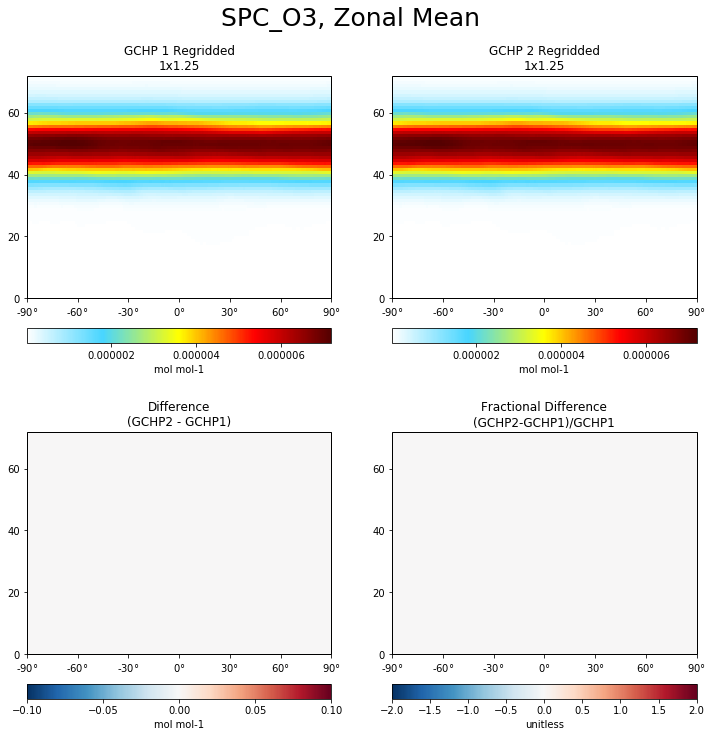

In [21]:
compare_zonal_mean(ds_gchp1, ds_gchp2, varlist=['SPC_O3'], weightsdir=weightsdir, flip_vert=True )

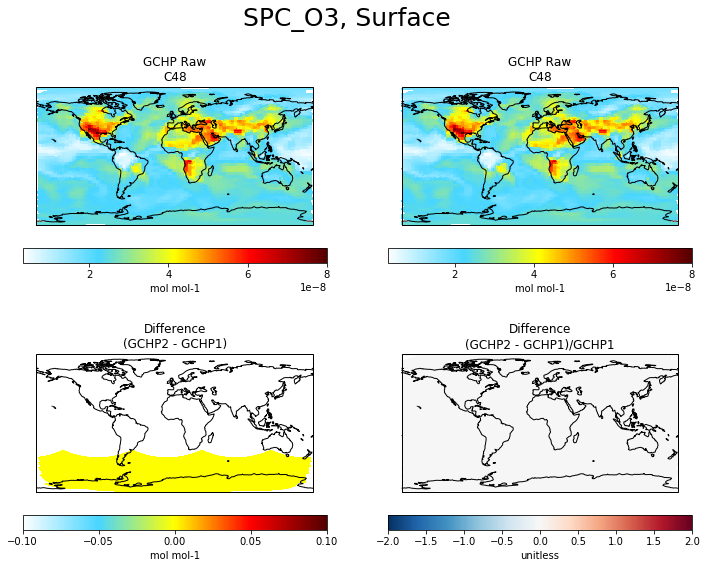

In [22]:
compare_single_level(ds_gchp1, ds_gchp2, varlist=['SPC_O3'], ilev=0, weightsdir=weightsdir, flip_vert=True )


## Store Grid Areas for Normalizing by Area

In [23]:
gchp1_collection = 'StateMet_avg'
gchp1_day = '20160701' # YYYYMMDD start date of time-averaging period
gchp1_time='1200'      # HHmm: GCC filename shows start time of time-averaging period

gchp2_collection = 'StateMet_avg'
gchp2_day = '20160701' # YYYYMMDD
gchp2_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gchp1_met = get_gchp_filepath(gchp1datadir, gchp1_collection, gchp1_day, gchp1_time)
gchp2_met = get_gchp_filepath(gchp2datadir, gchp2_collection, gchp2_day, gchp2_time)
check_paths(gchp1_met, gchp2_met)

First GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/GCHP.StateMet_avg.20160701_1200z.nc4
Second GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/GCHP.StateMet_avg.20160701_1200z.nc4


In [24]:
ds_gchp1_met = xr.open_dataset(gchp1_met)
ds_gchp2_met = xr.open_dataset(gchp2_met)
varname = 'Met_AREAM2'
gchp1_area = ds_gchp1_met[varname].isel(lev=0,time=0)
gchp2_area = ds_gchp2_met[varname].isel(lev=0,time=0)
print('GCHP 1 native grid area array shape: {}'.format(gchp1_area.shape))
print('GCHP 2 native grid area array shape: {}'.format(gchp2_area.shape))

GCHP 1 native grid area array shape: (540, 90)
GCHP 2 native grid area array shape: (540, 90)


## Compare diagnostic collections

## SpeciesConc

In [25]:
gchp1_collection = 'SpeciesConc_avg'
gchp1_day = '20160706' # YYYYMMDD start date of time-averaging period
gchp1_time='1200'      # HHmm: GCC filename shows start time of time-averaging period

gchp2_collection = 'SpeciesConc_avg'
gchp2_day = '20160706' # YYYYMMDD
gchp2_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gchp1_spc = get_gchp_filepath(gchp1datadir, gchp1_collection, gchp1_day, gchp1_time)
gchp2_spc = get_gchp_filepath(gchp2datadir, gchp2_collection, gchp2_day, gchp2_time)
check_paths(gchp1_spc, gchp2_spc)

First GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/GCHP.SpeciesConc_avg.20160706_1200z.nc4
Second GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/ifort17/gchp_standard_7day/OutputDir/GCHP.SpeciesConc_avg.20160706_1200z.nc4


In [26]:
ds_gchp1 = xr.open_dataset(gchp1_spc)
ds_gchp1

<xarray.Dataset>
Dimensions:               (lat: 540, lev: 72, lon: 90, time: 1)
Coordinates:
  * lon                   (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lat                   (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lev                   (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time                  (time) datetime64[ns] 2016-07-06T12:00:00
Data variables:
    SpeciesConc_ACET      (time, lev, lat, lon) float64 7.713e-10 8.087e-10 ...
    SpeciesConc_ACTA      (time, lev, lat, lon) float64 1.414e-12 1.531e-12 ...
    SpeciesConc_AERI      (time, lev, lat, lon) float64 1.238e-13 1.264e-13 ...
    SpeciesConc_ALD2      (time, lev, lat, lon) float64 1.954e-10 3.267e-10 ...
    SpeciesConc_ALK4      (time, lev, lat, lon) float64 1.507e-10 1.642e-10 ...
    SpeciesConc_BCPI      (time, lev, lat, lon) float64 8.568e-12 1.094e-11 ...
    SpeciesConc_BCPO      (time, lev, lat, lon) float64 3.643e-13 3.213e-13 ...
    SpeciesConc_BENZ  

In [27]:
ds_gchp2 = xr.open_dataset(gchp2_spc)
ds_gchp2

<xarray.Dataset>
Dimensions:               (lat: 540, lev: 72, lon: 90, time: 1)
Coordinates:
  * lon                   (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lat                   (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lev                   (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time                  (time) datetime64[ns] 2016-07-06T12:00:00
Data variables:
    SpeciesConc_ACET      (time, lev, lat, lon) float64 1.478e-09 1.644e-09 ...
    SpeciesConc_ACTA      (time, lev, lat, lon) float64 1.617e-12 1.791e-12 ...
    SpeciesConc_AERI      (time, lev, lat, lon) float64 1.315e-13 1.344e-13 ...
    SpeciesConc_ALD2      (time, lev, lat, lon) float64 3.198e-10 4.026e-10 ...
    SpeciesConc_ALK4      (time, lev, lat, lon) float64 1.51e-10 1.645e-10 ...
    SpeciesConc_BCPI      (time, lev, lat, lon) float64 8.568e-12 1.094e-11 ...
    SpeciesConc_BCPO      (time, lev, lat, lon) float64 3.643e-13 3.213e-13 ...
    SpeciesConc_BENZ   

In [28]:
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gchp1, ds_gchp2)

161 common variables (0 are 2-dim and 161 are 3-dim)


In [29]:
varname='SpeciesConc_ACET'
get_stats(ds_gchp1, ds_gchp2, varname)

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shapes:
    GCHP 1:  (1, 72, 540, 90)
    GCHP 2: (1, 72, 540, 90)
Global Mean:
    GCHP 1:  6.5654790945e-10
    GCHP 2: 8.0607464899e-10
Global Min:
    GCHP 1:  0.0
    GCHP 2: 0.0
Global Max:
    GCHP 1:  2.900027951114e-08
    GCHP 2: 2.898760520509e-08


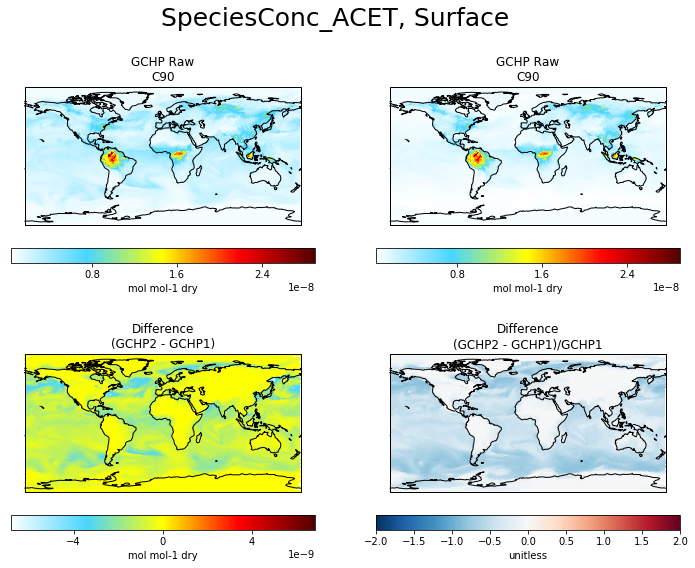

In [30]:
compare_single_level(ds_gchp1, ds_gchp2, varlist=[varname], weightsdir=weightsdir)

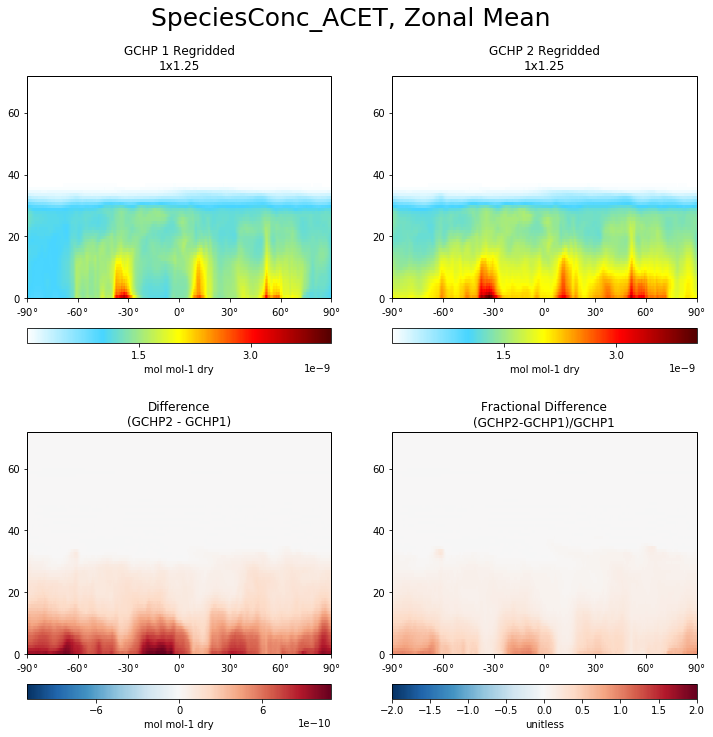

In [31]:
compare_zonal_mean(ds_gchp1, ds_gchp2, varlist=[varname], weightsdir=weightsdir )